# Experimental data

In contrast to theoretical or computational landscapes, like the Serine codon model shown in previous sections, empirical landscapes are based on experimental data. Such data is typically noisy and incomplete, so we need to apply additional methods to obtain reliable estimates of the phenotype of every possible genotype in order to visualize the genotype-phenotype map. In this section, we will illustrate the two methods available in `gpmap-tools` for inference of complete genotype-phenotype maps $f$ from noisy measurements `y` at a subset of sequences `X`. Optionally, the variance associated to the measurement `y_var` can be provided.

> **Note:** these methods only work for sequences of the same length

- **Minimum epistasis interpolation (MEI)** finds the genotype-phenotype map that minimizes the sum of squared P-th epistatic coefficients $\bar{\epsilon_P^2}$ while exactly matching the data `y` at sequences `X` ([read more](https://www.nature.com/articles/s41467-020-15512-5)).
- **Empirical VC regression** estimates a prior distribution characterized by the variance explained by interactions of every possible order from the empirical distance-correlation function computed from the available data. Then, it uses this prior distribution to perform Gaussian process regression to infer a complete genotype-phenotype map ([read more](https://doi.org/10.1073/pnas.2204233119)).

In this section, we will illustrate how to use these methods using simulated and real data and how to use them to evaluate the evidence supporting specific hypotheses about the genotype-phenotype map.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, norm
from gpmap.datasets import DataSet
from gpmap.inference import VCregression, MinimumEpistasisInterpolator
from gpmap.plot.mpl import plot_hyperparam_cv, init_fig

## Inference from simulated data

We first illustrate how to use these methods using simulated data. In this case, we know what the true genotype-phenotype map is and can compare the model inferences with the real values. 

### How to sample functions from the prior distribution

We will simulate data from the Variance Component regression model. In order to do so, we need to define the configuration of sequence space, the variance associated to interactions of every possible order `lambdas`, standard deviation of the measurement noise `sigma` and the fraction of genotypes that are not measured in the experiment `p_missing`.

In [2]:
np.random.seed(0)
lambdas_true = np.array([1e4, 1e3, 2e2, 1e0, 1e-1, 3e-3, 1e-5])

model = VCregression(seq_length=6, alphabet_type='dna', lambdas=lambdas_true)
data = model.simulate(sigma=0.2, p_missing=0.1)
test = data.loc[np.isnan(data["y"]), :].copy()
train = data.dropna()
train

,y_true,y,y_var
AAAAAA,-1.212747,-1.398312,0.04
AAAAAC,-3.876249,-3.494929,0.04
AAAAAG,0.140375,-0.066060,0.04
AAAAAT,1.159327,1.123854,0.04
AAAACA,0.336225,0.006149,0.04
...,...,...,...
TTTTGT,-4.808467,-4.818905,0.04
TTTTTA,-6.423852,-6.490532,0.04
TTTTTC,-0.621695,-0.666689,0.04
TTTTTG,-4.882427,-4.986013,0.04


### How to compute the minimum epistasis interpolation solution

This can be done very simply by defining a `MinimumEpistasisInterpolator` object with the right configuration of sequence space and the order of local epistatic coefficients we aim to penalize. In this case, we set `P=2` to minimize the sum of squared epistatic coefficients.

In [3]:
model = MinimumEpistasisInterpolator(P=2, seq_length=6, alphabet_type='dna')
model.set_data(X=train.index.values, y=train['y'].values)
mei = model.predict()
mei

,y
AAAAAA,-1.398312
AAAAAC,-3.494929
AAAAAG,-0.066060
AAAAAT,1.123854
AAAACA,0.006149
...,...
TTTTGT,-4.818905
TTTTTA,-6.490532
TTTTTC,-0.666689
TTTTTG,-4.986013


We can now compare the predicted with the true phenotype at the held-out test sequences

Text(0.03, 0.97, '$R^2$=0.990')

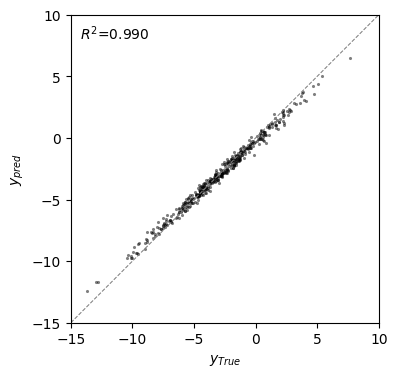

In [4]:
test = test.join(mei, rsuffix="_mei")
r2 = pearsonr(test['y_mei'], test['y_true'])[0] ** 2
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.scatter(x=test['y_true'], y=test['y_mei'], c='black', alpha=0.5, s=5, lw=0)
ticks = np.arange(-10, 9, 2)
axes.axline((0, 0), (1, 1), lw=0.75, linestyle='--', c='grey')
axes.set(xlabel=r'$y_{True}$', ylabel=r'$y_{pred}$', aspect='equal', xlim=(-15, 10), ylim=(-15, 10))
axes.text(0.03, 0.97, r'$R^2$=' + '{:.3f}'.format(r2), transform=axes.transAxes,
          va='top')

This comparison shows a very high correlation between the predictions and the real phenotypic values, but the extremely low and high values tend to be over and underestimated, respectively. 

### How to estimate Variance Components $\lambda$'s

We next illustrate how to use Variance Component regression on the same simulated data for comparison. The first step is the estimation of the variance components from the data. The covariance matrix $K$ under the prior is given by

$$K = \sum_k \lambda_k K_k$$

We define the $\lambda_k$ through kernel alignment. This is achieved by finding the non-negative linear combination of the covariance matrices $K_k$ associated to each pure interactions of order $k$ that that minimize the Frobenius norm of the difference with the empirical second moment matrix $(y - \bar y)^T(y - \bar y)$ 

$$\hat\lambda = \arg \min_{\lambda} \lVert (y - \bar y)(y - \bar y)^T - (\sum_k \lambda_k K_k)_{xx} \lVert_F^2$$




In [5]:
model = VCregression(seq_length=6, alphabet_type="dna", )
model.fit(X=train.index.values, y=train.y.values, y_var=train.y_var.values)
vc = model.lambdas_to_variance(model.lambdas)
vc_p = vc / vc.sum() * 100

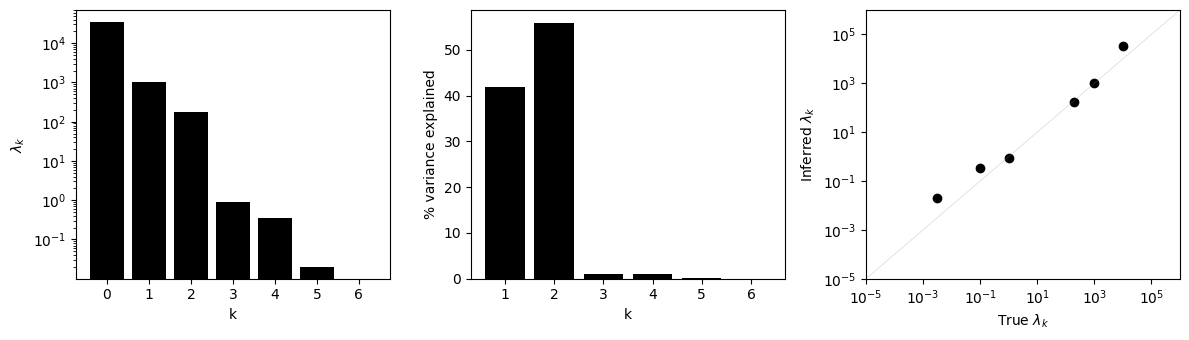

In [6]:
k = np.arange(model.lambdas.shape[0])

fig, subplots = plt.subplots(1, 3, figsize=(12, 3.5))

axes = subplots[0]
axes.bar(x=k, height=model.lambdas, color='black')
axes.set(xlabel='k', ylabel=r'$\lambda_k$', yscale='log',
         xticks=np.arange(7))

axes = subplots[1]
axes.bar(x=k[1:], height=vc_p, color='black')
axes.set(xlabel='k', ylabel='% variance explained')

axes = subplots[2]
axes.scatter(lambdas_true, model.lambdas, c='black')
lims = (1e-5, 1e6)
axes.plot(lims, lims, c='grey', lw=0.3, alpha=0.5)
axes.set(xscale='log', yscale='log',
         xlabel=r'True $\lambda_k$',
         ylabel=r'Inferred $\lambda_k$',
         xlim=lims, ylim=lims)

fig.tight_layout()

We can see that the inferred variance components are very similar in log scale to the true data-generating parameters. 

However, when data is sparse, kernel alignment is a hard problem and we need to regularize towards simpler solutions. While we could shrink towards additivity, another good general choice that still models high order interactions is towards exponential decay of the variance components. We can do it by setting `cross_validation=True` and penalizing the second order moments of the $\log \lambda_k$ as a function of $k$. It will automatically split the data into different folds and perform kernel alignment under different regularization strength to find the penalization constant that best generalizes to the validation set according to a metric. These metrics can be
the Frobenius  of the difference between the prior and second moment matrix, $R^2$ on the or the log-likelihood of the predictions on the validation set. This can be specified through the argument `cv_loss_function='r2'` ,`cv_loss_function='logL'`.

In [7]:
cvmodel = VCregression(cross_validation=True, cv_loss_function='logL', max_log_beta=5)
cvmodel.fit(X=train.index.values, y=train.y.values, y_var=train.y_var.values)

100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


We can visualize the hyperparameter optimization curves during the cross-validation procedure as follows

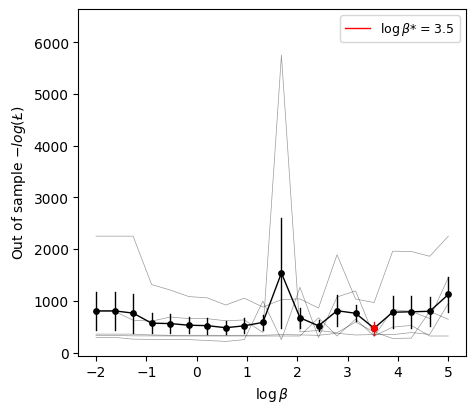

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4.5))
plot_hyperparam_cv(cvmodel.cv_loss_df, axes, x='log_beta', y='loss', show_folds=True,
                   xlabel=r'$\log\beta$', ylabel=r'$-log(\L)$', highlight='min')

### How to obtain phenotypic predictions under a VC prior

Once we know the parameters of the Variance Component prior, we can compute the posterior distribution for the complete genotype-phenotype map with the method `predict`

In [9]:
model.fit(X=train.index.values, y=train.y.values, y_var=train.y_var.values)
pred = model.predict()
pred

,y
AAAAAA,-1.351140
AAAAAC,-3.791511
AAAAAG,0.044138
AAAAAT,1.201937
AAAACA,0.015829
...,...
TTTTGT,-4.682707
TTTTTA,-6.418972
TTTTTC,-0.733215
TTTTTG,-4.964112


We can now compare the predictions with the true phenotypic values in held-out sequences, achieving better predictive performance than with MEI.

Text(0.03, 0.97, '$R^2$=0.997')

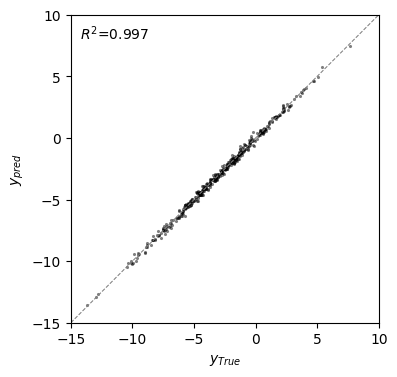

In [10]:
test = test.join(pred, rsuffix="_pred")
r2 = pearsonr(test["y_pred"], test["y_true"])[0] ** 2
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.scatter(x=test["y_true"], y=test["y_pred"], c="black", alpha=0.5, s=5, lw=0)
ticks = np.arange(-10, 9, 2)
axes.axline((0, 0), (1, 1), lw=0.75, linestyle="--", c="grey")
axes.set(
    xlabel=r"$y_{True}$",
    ylabel=r"$y_{pred}$",
    aspect="equal",
    xlim=(-15, 10),
    ylim=(-15, 10),
)
axes.text(
    0.03,
    0.97,
    r"$R^2$=" + "{:.3f}".format(r2),
    transform=axes.transAxes,
    va="top",
)


### How to calculate uncertainty of the predictions

In the previous section, we have shown how to compute the posterior mean of the complete genotype-phenotype given the data and the estimated variance components. However, in cases where the ground truth is not known, it can be useful to have an idea about the uncertainty of the phenotypic predictions for new sequences. As we are using Gaussian process models with Gaussian likelihood function, we can compute, not only the posterior mean, but also the posterior variance and 95% probability credible interval for these sequences by setting `calc_variance=True`.

> **Note**: Computing the variance for every possible sequence is usually unfeasible because we need to solve a system of $~\alpha^\ell$ equations for computing the variance of each sequence. Thus, in practice, this calculation can only be done for a small subset of sequences of interest.



In [11]:
pred = model.predict(test.index.values, calc_variance=True)
pred['y_true'] = data.loc[pred.index.values, 'y_true']
pred

100%|██████████| 438/438 [00:19<00:00, 22.07it/s]


,y,y_var,std,ci_95_lower,ci_95_upper,y_true
AAAAGG,-4.655712,0.053484,0.231267,-5.118245,-4.193179,-4.490122
AAAATC,-4.664899,0.053372,0.231024,-5.126947,-4.202851,-4.563295
AAACGC,-3.764736,0.056246,0.237162,-4.239060,-3.290411,-3.762022
AAAGCT,-2.354579,0.053003,0.230223,-2.815025,-1.894133,-2.278915
AAAGGC,-4.055686,0.053139,0.230520,-4.516725,-3.594647,-4.166181
...,...,...,...,...,...,...
TTTCGT,-3.948662,0.056216,0.237100,-4.422861,-3.474463,-4.078485
TTTGAA,-7.868073,0.059309,0.243534,-8.355140,-7.381005,-7.812920
TTTGAT,-5.302352,0.056146,0.236952,-5.776257,-4.828448,-5.469751
TTTGTA,-10.177815,0.056164,0.236989,-10.651794,-9.703837,-10.371402


We can now check that predictions are well calibrated, this is, that the true value lies withing the 95% probability predicted interval close to the expected 95% probability; and show the error bars in the scatterplot to visualize if uncertainty is uniformly distributed along the whole range of true phenotypic values.

Text(0.03, 0.97, 'Calibration=98.63%')

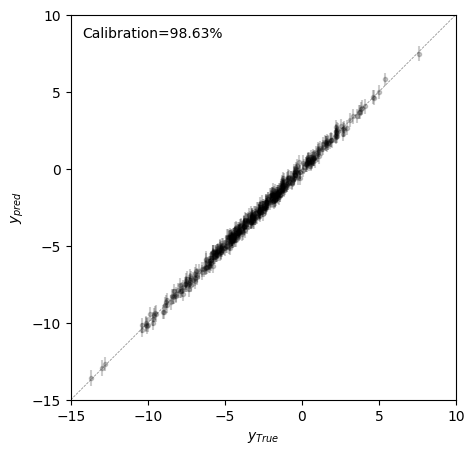

In [12]:
perc = np.mean((pred['y_true'] > pred['ci_95_lower']) & (pred['y_true'] < pred['ci_95_upper'])) * 100
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.errorbar(x=pred['y_true'], y=pred['y'], yerr=2 * pred['std'], c='black', markersize=3, fmt='o', alpha=0.2)
axes.axline((0, 0), (1, 1), lw=0.5, c='grey', linestyle='--')
axes.set(
    xlabel=r"$y_{True}$",
    ylabel=r"$y_{pred}$",
    aspect=1,
    xlim=(-15, 10),
    ylim=(-15, 10),
)
axes.text(0.03, 0.97, 'Calibration={:.2f}%'.format(perc), transform=axes.transAxes, va='top')

### How to estimate mutational effects and epistatic coefficients under the prior

Because the posterior distribution of the sequence function relationship is also a multivariate gaussian, 

$$
f \sim MvNormal(\mu, \Sigma)
$$

We can easily compute the posterior for any linear combination represented by $B$ of a multivariate normal distribution

$$
Bf \sim MvNormal(B\mu, B\Sigma B^T)
$$

Without any prior distribution, we can assume that $\Sigma=D_{\sigma^2}$ and $\mu=y$, and use the following function to compute the posterior distribution for specific linear combinations given by the contrast matrix $B$ 


In [13]:
def make_contrasts(df, contrast_matrix):
    f = df['y']
    Sigma = np.diag(df['y_var'])
    B = contrast_matrix.T.values
    mu = B @ f
    std = np.sqrt(np.diag(B @ Sigma @ B.T))
    posterior = norm(mu, std)
    p = posterior.cdf(0.)
    p = np.max(np.vstack([p, 1-p]), axis=0)
    contrasts = pd.DataFrame({'estimate': mu, 'std': std, 
                              'ci_95_lower': mu - 2 * std, 
                              'ci_95_upper': mu + 2 * std,  
                              'p(|x|>0)': p}, 
                              index=contrast_matrix.columns)
    return(contrasts)

Lets start by estimating mutational effects from`TTTTTT` to `TTTTTC`:

In [14]:
seqs = ['TTTTTT', 'TTTTTC']
df = data.loc[seqs, :]
df

,y_true,y,y_var
TTTTTT,-2.149232,-2.358559,0.04
TTTTTC,-0.621695,-0.666689,0.04


In [15]:
contrast_matrix = pd.DataFrame({'T6C': [1, -1]}, index=['TTTTTT', 'TTTTTC'])
contrast_matrix

,T6C
TTTTTT,1
TTTTTC,-1


Lets start by computing the true mutational effect from the simulated genotype-phenotype map

In [16]:
true_effect = (contrast_matrix.T.values @ df['y_true'].values)[0]
print('True mutational effect = {:.2f}'.format(true_effect))

True mutational effect = -1.53


and compare it with our naive posterior estimate.

In [17]:
contrasts = make_contrasts(df, contrast_matrix)
mu = contrasts.loc['T6C', 'estimate']
lower = contrasts.loc['T6C', 'ci_95_lower']
upper = contrasts.loc['T6C', 'ci_95_upper']
print('Estimated mutational effect = {:.2f} (95% CI = [{:.2f}, {:2f}])'.format(mu, lower, upper))

Estimated mutational effect = -1.69 (95% CI = [-2.26, -1.126184])


We can see that the true effect is relatively close to the inferred one, and is within the 95% credible interval. However, the 95% credible interval is quite wide. Thus, can we do better by including taking into account our prior distribution?

We can do the same calculations using the `make_contrast` method provided any user-defined `contrast_matrix`

In [18]:
contrasts = model.make_contrasts(contrast_matrix=contrast_matrix)
mu = contrasts.loc['T6C', 'estimate']
lower = contrasts.loc['T6C', 'ci_95_lower']
upper = contrasts.loc['T6C', 'ci_95_upper']
print('Estimated mutational effect with GP prior = {:.2f} (95% CI = [{:.2f}, {:2f}])'.format(mu, lower, upper))

100%|██████████| 2/2 [00:00<00:00, 16.39it/s]

Estimated mutational effect with GP prior = -1.58 (95% CI = [-1.98, -1.185415])


Thus, we can see how the estimate now is closer to the true simulated mutational effect and that the posterior distribution is tighter around it, illustrating that we have less uncertainty about its effect when taking into account the observed mutational effects across all genetic backgrounds appropriately.

We can do these analyses not only for mutational effects, but also for epistatic coefficients of any order. Lets see how the previous mutational effect changes when we add a T0A mutation at the first position:

In [19]:
seqs = ['TTTTTT', 'TTTTTC', 'ATTTTT', 'ATTTTC']
df = data.loc[seqs, :]
df

,y_true,y,y_var
TTTTTT,-2.149232,-2.358559,0.04
TTTTTC,-0.621695,-0.666689,0.04
ATTTTT,0.040943,0.070038,0.04
ATTTTC,-3.423259,-3.570027,0.04


Lets do it again first without using our prior distribution

In [20]:
contrast_matrix = pd.DataFrame({'epistatic_coeff': [1, -1, -1, 1]},
                                index=seqs)
contrast_matrix

,epistatic_coeff
TTTTTT,1
TTTTTC,-1
ATTTTT,-1
ATTTTC,1


In [21]:
true_effect = (contrast_matrix.T.values @ df['y_true'].values)[0]
print('True epistatic coefficient = {:.2f}'.format(true_effect))

True epistatic coefficient = -4.99


In [22]:
contrasts = make_contrasts(df, contrast_matrix)
mu = contrasts.loc['epistatic_coeff', 'estimate']
lower = contrasts.loc['epistatic_coeff', 'ci_95_lower']
upper = contrasts.loc['epistatic_coeff', 'ci_95_upper']
print('Estimated epistatic coefficient = {:.2f} (95% CI = [{:.2f}, {:2f}])'.format(mu, lower, upper))

Estimated epistatic coefficient = -5.33 (95% CI = [-6.13, -4.531935])


In [23]:
contrasts = model.make_contrasts(contrast_matrix=contrast_matrix)
mu = contrasts.loc['epistatic_coeff', 'estimate']
lower = contrasts.loc['epistatic_coeff', 'ci_95_lower']
upper = contrasts.loc['epistatic_coeff', 'ci_95_upper']
print('Estimated epistatic coefficient with GP prior = {:.2f} (95% CI = [{:.2f}, {:2f}])'.format(mu, lower, upper))

100%|██████████| 2/2 [00:00<00:00, 11.71it/s]

Estimated epistatic coefficient with GP prior = -5.15 (95% CI = [-5.67, -4.636860])


Again, we see how incorporation the prior knowledge about how well mutational effects generalize across genetic backgrounds provides a better estimate of the true epistatic coefficient and a tighter credible interval around it.

## Inference from real data: protein GB1

In the next section, we are going to infer the complete combinatorial landscape of the protein G domain B1 from experimental data [[Wu et. al (2016)](https://elifesciences.org/articles/16965)]. In this study, a library containing nearly all possible aminoacid combinations at positions 39, 40, 41 and 54 was selected for binding to the constant fraction of IgG using an mRNA display approach. Thus, by sequencing the mRNA library before and after selection, we can obtain estimates of how strongly each sequence in the library binds its target. 

### Data preprocessing

We take the number of times a sequence is observed in the input and selected samples as raw data for our purposes as provided by the authors [here](https://elifesciences.org/articles/16965/figures#SD1-data).

In [24]:
gb1 = DataSet('gb1')
counts = gb1.raw_data
counts

,input,selected
sequence,,
VDGV,92735,338346
ADGV,34,43
CDGV,850,641
DDGV,63,63
EDGV,841,190
...,...,...
YYYR,203,1
YYYS,186,3
YYYT,181,14


We first filter sequences that are poorly represented in the input library (<20 sequencing counts).

In [25]:
counts = counts.loc[counts['input'] >= 20, :]
counts

,input,selected
sequence,,
VDGV,92735,338346
ADGV,34,43
CDGV,850,641
DDGV,63,63
EDGV,841,190
...,...,...
YYYR,203,1
YYYS,186,3
YYYT,181,14


And use [Enrich2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1272-5) approach to derive the enrichment score and the associated error. 

$$y_i = log\left(\frac{ c_{i,sel} + 0.5}{c_{wt,sel} + 0.5} \right) - log\left(\frac{ c_{i,inp} + 0.5}{c_{wt,inp} + 0.5} \right)$$


$$y_{var,i} = \frac{1}{c_{i,inp} + 0.5} + \frac{1}{c_{wt,inp} + 0.5} + \frac{1}{c_{i,sel} + 0.5} +\frac{1}{c_{wt,sel} + 0.5}$$


In [26]:
wt = 'VDGV'
c_wt_input, c_wt_sel = counts.loc[wt]
X = counts.index.values
y = (np.log((counts['selected'] + 0.5)/(c_wt_sel + 0.5)) - np.log((counts['input'] + 0.5)/(c_wt_input + 0.5))).values
y_var = (1/(counts['input'] + 0.5) + 1/(counts['selected'] + 0.5) + 1/(c_wt_sel + 0.5) + 1/(c_wt_input + 0.5)).values
data = pd.DataFrame({'y': y, 'y_var': y_var}, index=X)

To be able to evaluate model performance, we first split the data into training and test sets keeping approximately 90% of the data for training and 10% for testing

In [27]:
u = np.random.uniform(size=y.shape[0]) < 0.9
X_train, y_train, y_var_train = X[u], y[u], y_var[u]
X_test, y_test = X[~u], y[~u]

### Computing the minumum epistasis interpolation solution

In [28]:
model = MinimumEpistasisInterpolator(P=2, seq_length=4, alphabet_type='protein')
model.set_data(X_train, y_train)
mei = model.predict()
mei

,y
AAAA,0.460831
AAAC,-2.475830
AAAD,-3.568728
AAAE,-4.868209
AAAF,-4.007796
...,...
YYYS,-5.269987
YYYT,-3.821426
YYYV,-3.143536
YYYW,-4.306581


Text(0.05, 0.95, '$R^2$=0.832')

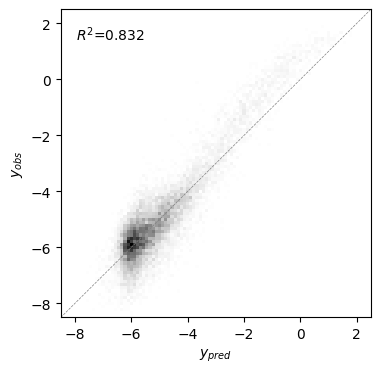

In [29]:
lim = (-9, 3)
r2 = pearsonr(mei.loc[X_test, 'y'], y_test)[0] ** 2
bins = np.linspace(lim[0] + 0.5, lim[1] - 0.5, 100)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.hist2d(x=mei.loc[X_test, 'y'], y=y_test, cmap="binary", bins=bins)
axes.axline((0, 0), (1, 1), lw=0.5, linestyle="--", c="grey")
axes.set(
    xlabel=r"$y_{pred}$",
    ylabel=r"$y_{obs}$",
    xlim=(lim[0] + 0.5, lim[1] - 0.5),
    ylim=(lim[0] + 0.5, lim[1] - 0.5),
)
axes.text(
    0.05,
    0.95,
    r"$R^2$=" + "{:.3f}".format(r2),
    transform=axes.transAxes,
    color="black",
    ha="left",
    va="top",
)



### Estimating Variance Components

In [30]:
model = VCregression(seq_length=4, alphabet_type='protein')
model.fit(X=X_train, y=y_train, y_var=y_var_train)

In [31]:
lambdas = model.lambdas
x = np.arange(0, lambdas.shape[0])
variance = model.lambdas_to_variance(lambdas)
p_variance = variance / variance.sum() * 100

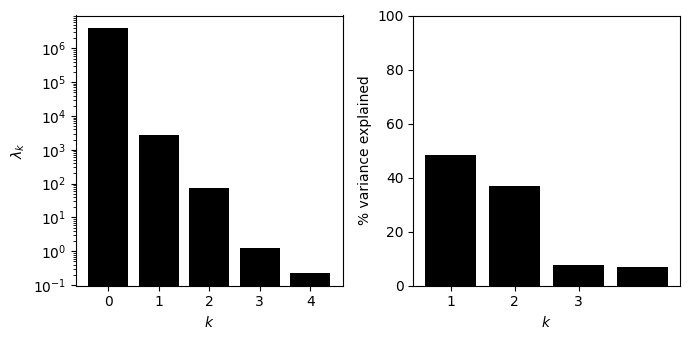

In [32]:
fig, subplots = init_fig(1, 2, colsize=3.5, rowsize=3.5)

axes = subplots[0]
axes.bar(x=x, height=lambdas, color='black')
axes.set(xlabel='$k$', ylabel='$\lambda_k$', yscale='log')

axes = subplots[1]
axes.bar(x=x[1:], height=p_variance, color='black')
axes.set(xlabel='$k$', ylabel='% variance explained', ylim=(0, 100), xticks=[1, 2, 3])

fig.tight_layout()

### Inferring the complete GB1 landscape

Now that we have inferred the variance components, we obtain inferences for the complete combinatorial landscape and check the prediction accuracy for the held-out test data. Moreover, we can also see the distribution of phenotypic values within and outside the data

In [33]:
pred = model.predict().join(data, lsuffix='_pred')
pred

,y_pred,y,y_var
AAAA,0.399348,0.460831,0.046009
AAAC,-2.551728,NaN,NaN
AAAD,-3.454428,NaN,NaN
AAAE,-4.783908,NaN,NaN
AAAF,-3.685388,NaN,NaN
...,...,...,...
YYYS,-4.822342,-5.269987,0.291090
YYYT,-3.635390,-3.821426,0.074489
YYYV,-3.123463,-3.143536,0.074682
YYYW,-4.837803,-4.306581,0.699467


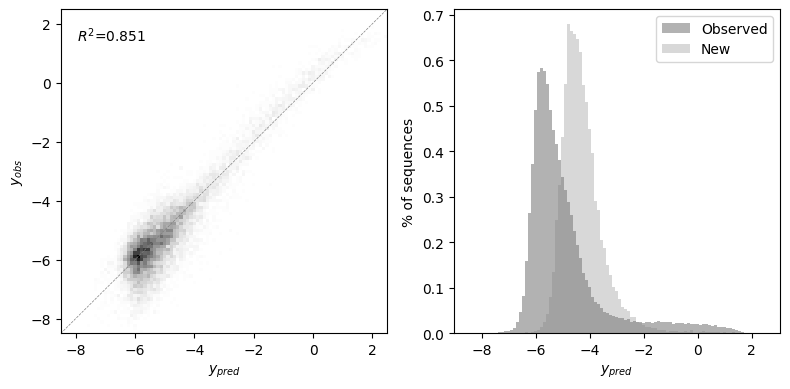

In [34]:
test = pred.loc[X_test, :]
r2 = pearsonr(test['y_pred'], test['y'])[0] ** 2
lim = (-9, 3)
bins = np.linspace(lim[0] + 0.5, lim[1] - 0.5, 100)

fig, subplots = plt.subplots(1, 2, figsize=(8, 4))

axes = subplots[0]
axes.hist2d(x=test['y_pred'], y=test['y'], cmap='binary', bins=bins)
axes.axline((0, 0), (1, 1), lw=0.5, linestyle='--', c='grey')
axes.set(xlabel=r'$y_{pred}$', ylabel=r'$y_{obs}$',
         xlim=(lim[0] + 0.5, lim[1] - 0.5),
         ylim=(lim[0] + 0.5, lim[1] - 0.5))
axes.text(0.05, 0.95, r'$R^2$=' + '{:.3f}'.format(r2),
          transform=axes.transAxes, color='black', ha='left', va='top')

axes = subplots[1]
axes.hist(pred.dropna()['y_pred'], label='Observed', alpha=0.3, density=True, bins=bins, color='black')
axes.hist(pred.loc[np.isnan(pred['y']), 'y_pred'], label='New', alpha=0.3, density=True, bins=bins, color='grey')
axes.set(xlabel=r'$y_{pred}$', ylabel='% of sequences')
axes.legend(loc=0)

fig.tight_layout()

### Estimating local epistatic coefficients under the prior

As previously shown, we are not only restricted to making calibrated predictions for previously uncharacterized or held out sequences, but we can also get calibrated estimates for linear combinations of them and use them to answer questions about specific mutational effects and how they change as we introduced more mutations.

One of the main interactions in the GB1 dataset is that taking place between positions 41 and 54. In the wild-type sequence VDGV, G41L is highly deleterious, but becomes advantageous in the presence of V54G. Now, we can use our model to compute the posterior distribution for this epistatic coefficient given the whole dataset. 

We can select the 4 relevant sequences and show their measurement values

In [35]:
seqs = ['VDGV', 'VDGG', 'VDLV', 'VDLG']
df = data.loc[seqs, :]
df

,y,y_var
VDGV,0.000000,0.000027
VDGG,0.334153,0.003038
VDLV,-3.512487,0.105615
VDLG,1.140357,0.013197


We then define the contrast matrices for the coefficients of interest: the single point mutational effects as well as the epistatic coefficient between them.

In [36]:
contrast_matrix = pd.DataFrame({'G41L'     : [-1,  0,  1,  0],
                                'V54G'     : [-1,  1,  0,  0],
                                'G41L:V54G': [ 1, -1, -1,  1]},
                                index=seqs)
contrast = model.make_contrasts(contrast_matrix)
contrast

100%|██████████| 3/3 [00:18<00:00,  6.08s/it]


,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
G41L,-3.376735,0.277964,-3.932662,-2.820807,1.0
V54G,0.318694,0.055069,0.208557,0.428832,1.0
G41L:V54G,4.208261,0.303865,3.600531,4.815991,1.0


We can see that there is strong support in the posterior for the deleterious effect of G41L in the wild-type background, but also that this is strongly reversed in the presence of V54G. Lets now compare these estimates with the naive comparisons using the estimated measurement errors alone

In [37]:
make_contrasts(df, contrast_matrix)

,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
G41L,-3.512487,0.325026,-4.162539,-2.862435,1.0
V54G,0.334153,0.055370,0.223413,0.444892,1.0
G41L:V54G,4.318691,0.349109,3.620472,5.016910,1.0


We can see how estimates are then shrunk towards 0 and uncertaintly is slightly reduced by using the prior that was estimated across the complete dataset